In [5]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional, Masking
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [7]:
data = pd.read_csv("/kaggle/input/amazon-fine-food-reviews/Reviews.csv", nrows = 100000)
data

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."
...,...,...,...,...,...,...,...,...,...,...
99995,99996,B000LQORDE,A2P7HIRYYWVOBD,Mason,2,5,5,1254096000,yummy!,I just love it and will buy another box when I'm done with last one!
99996,99997,B000LQORDE,A1K0ZH5MQFBA77,jennilight,2,5,4,1250985600,Tastes like More!,"My late father in law used to have a rating system for meals: if it was particularly tasty, he'd say ""This tastes like more!"" That's exactly how I felt the first time I tried a spicy picante ramyu..."
99997,99998,B000LQORDE,A29FRN2O7LWINL,T. Tsai,2,5,5,1237766400,Great ramen,"This is my favorite brand of Korean ramen. It is spicy so if you are not used to eating spicy food, make sure you don't use all of the spice pack. If you add an egg to the soup, it makes a great s..."
99998,99999,B000LQORDE,A9Q950IPXJR1D,"Lynda ""casual customer""",2,5,4,1237161600,Spicy!!,"I do like these noodles although, to say they are spicy is somewhat of an understatement. No one else in the family tolerates spicy very well so, seeing these, I was looking forward to an extra li..."


In [8]:
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer

max_words = 100000
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(data['Text'])

In [9]:
#save tokenier
with open("tokenizer.pkl", "wb") as token_file:
    pickle.dump(tokenizer, token_file)

In [10]:
data.drop_duplicates(subset=['Text'], inplace=True) #dropping duplicates
data.dropna(axis=0, inplace=True)

In [11]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [12]:
data['Text'][:10]

0    I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1             Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".
2    This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ...
3    If you are looking for the secret ingredient in Robitussin I believe I have found it.  I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda.  The fl...
4                                                               Great taffy at a great price.  There was a wide assortment of yummy taffy.  Delivery was very quick.  If your a taff

In [13]:
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t))
data['cleaned_text'] = cleaned_text

In [14]:
def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString

#Call the above function
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(summary_cleaner(t))

data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary
data['cleaned_summary'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

In [15]:
data['cleaned_summary'] = data['cleaned_summary'].apply(lambda x: '_START_'+x+'_END_')

In [16]:
for i in range(5):
    print("Article:", data['cleaned_text'][i])
    print("Summary:", data['cleaned_summary'][i])
    print("\n")

Article: bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary: _START_good quality dog food _END_


Article: product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary: _START_not as advertised _END_


Article: confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
Summary: _START_delight says it all _END_


Article: looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal
Summary: _START_cough medicine _END_


Article: great taffy great price wide assortment yummy taffy delivery quick taffy lover

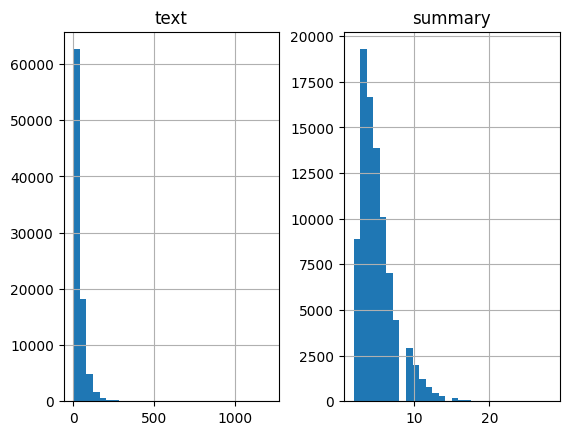

In [17]:
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []
# populate the lists with sentence lengths
for i in data['cleaned_text']:
    text_word_count.append(len(i.split()))
for i in data['cleaned_summary']:
    summary_word_count.append(len(i.split()))
length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [18]:
max_len_text=200
max_len_summary=10

In [19]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(data['cleaned_text'],data['cleaned_summary'],test_size=0.1,random_state=0,shuffle=True)

In [20]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))
#convert text sequences into integer sequences
x_tr = x_tokenizer.texts_to_sequences(x_tr)
x_val = x_tokenizer.texts_to_sequences(x_val)
#padding zero upto maximum length
x_tr = pad_sequences(x_tr, maxlen=max_len_text, padding='post')
x_val = pad_sequences(x_val, maxlen=max_len_text, padding='post')
x_voc_size = len(x_tokenizer.word_index) +1

In [21]:
#preparing a tokenizer for summary on training data
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))
#convert summary sequences into integer sequences
y_tr = y_tokenizer.texts_to_sequences(y_tr)
y_val = y_tokenizer.texts_to_sequences(y_val)
#padding zero upto maximum length
y_tr = pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val = pad_sequences(y_val, maxlen=max_len_summary, padding='post')
y_voc_size = len(y_tokenizer.word_index) +1

In [22]:
from keras import backend as K 
K.clear_session() 
latent_dim = 500 

# Encoder 
encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb = Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])  

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 200, 500)             2588650   ['input_1[0][0]']             
                                                          0                                       
                                                                                                  
 lstm (LSTM)                 [(None, 200, 500),           2002000   ['embedding[0][0]']           
                              (None, 500),                                                        
                              (None, 500)]                                                    

In [24]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [25]:
es = EarlyStopping(monitor='val_accuracy',
                   mode='max',
                   verbose=1)

In [26]:
history = model.fit([x_tr, y_tr[:, :-1]], y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:],
                    epochs=50, callbacks=[es], batch_size=256,
                    validation_data=([x_val, y_val[:, :-1]], y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:, 1:]))

Epoch 1/50
311/311 [==============================] - 147s 451ms/step - loss: 3.4274 - accuracy: 0.5364 - val_loss: 2.9594 - val_accuracy: 0.5908
Epoch 2/50
311/311 [==============================] - 138s 445ms/step - loss: 3.0363 - accuracy: 0.5824 - val_loss: 2.8757 - val_accuracy: 0.5945
Epoch 3/50
311/311 [==============================] - 138s 444ms/step - loss: 2.9490 - accuracy: 0.5879 - val_loss: 2.8146 - val_accuracy: 0.6002
Epoch 4/50
311/311 [==============================] - 138s 445ms/step - loss: 2.8875 - accuracy: 0.5914 - val_loss: 2.7639 - val_accuracy: 0.6009
Epoch 5/50
311/311 [==============================] - 138s 444ms/step - loss: 2.8388 - accuracy: 0.5954 - val_loss: 2.7212 - val_accuracy: 0.6055
Epoch 6/50
311/311 [==============================] - 138s 443ms/step - loss: 2.7933 - accuracy: 0.5987 - val_loss: 2.6803 - val_accuracy: 0.6097
Epoch 7/50
311/311 [==============================] - 138s 443ms/step - loss: 2.7508 - accuracy: 0.6014 - val_loss: 2.6483 -

In [27]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
print("Training Accuracy: ", train_accuracy[-1])
print("Validation Accuracy: ", val_accuracy[-1])

Training Accuracy:  0.6157622337341309
Validation Accuracy:  0.6228258609771729


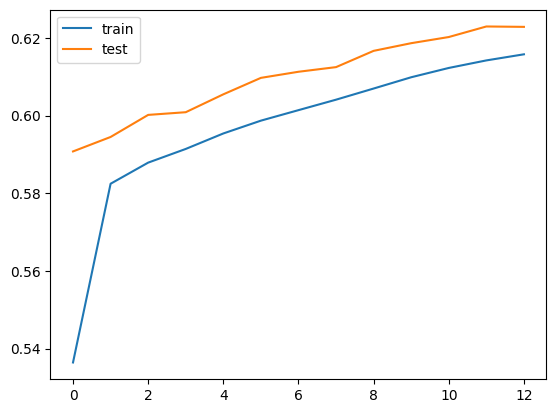

In [28]:
!pip install matplotlib
from matplotlib import pyplot 
pyplot.plot(history.history['accuracy'], label='train') 
pyplot.plot(history.history['val_accuracy'], label='test') 
pyplot.legend()
pyplot.show()

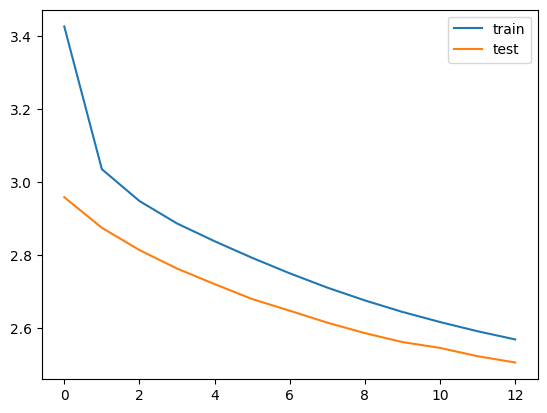

In [35]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend()
pyplot.show()

In [36]:
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

In [37]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
#attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [38]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index.get(sampled_token_index, 'unknown_token')

        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token
            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
                stop_condition = True
        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        # Update internal states
        e_h, e_c = h, c
    return decoded_sentence

In [39]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

In [40]:
for i in range(50):
  print("Review:",seq2text(x_val[i]))
  print("Original summary:",seq2summary(y_val[i]))
  print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_len_text)))
  print("\n")

Review: loves things though think taste nasty hahaha actually learned chew gums matter picky pull eat know carbs best thing least know organic cheese puff buying amazon saved money stores three dollars 
Original summary: this is my daughter favorite snack 
1/1 [==============================] - 0s 21ms/step
Predicted summary:  great product unknown_token unknown_token unknown_token unknown_token unknown_token unknown_token unknown_token


Review: yes block awesome bought many times processed cheese real deal aged sharp cheddar made found last holiday season love nippy mild deliciously great large serving block uncut pounds nutrition inch cube calories fat grams sodium cholesterol carbs zero trans fats saturated fat grams protein grams excellent chop appetizers party trays due extra large block size cut sandwhich size slices huge thick block perfect uncut unprocessed nice product deli direct compliments cheese spreads wraps rolled sandwiches ten stars consistent customer months 
Origina

In [34]:
model.save('/kaggle/working/summarizer.h5')